In [ ]:
import pandas as pd
import numpy as np
from pandas import json_normalize
from datetime import date, datetime, timedelta
import json
import pytz
from square.client import Client

client = Client(
  access_token="",
  environment="production"
)

pd.set_option('display.max_columns', None)

date_param = date.today().strftime("%Y-%m-%d")
timezone = pytz.timezone('Canada/Mountain')

start_datetime = datetime.strptime('2025-04-01',  "%Y-%m-%d")
end_datetime = datetime.strptime('2025-05-08',  "%Y-%m-%d")

# Convert to ISO 8601 format for Square API
start_time = start_datetime.isoformat()
end_time = end_datetime.isoformat()

/var/folders/gg/bq9f4z_51wzf2n5834ds3hmc0000gn/T/ipykernel_4158/3729991147.py:11: DeprecationWarning: The 'access_token' params are deprecated. Use 'bearer_auth_credentials' param instead.
  client = Client(


In [35]:
# Function to process payments and store them in a DataFrame
def process_payments(response_body, df=None):
    # If DataFrame is not initialized, create one
    if df is None:
        df = pd.DataFrame()

    # Append new payments to the DataFrame
    df = pd.concat([df, pd.DataFrame(json_normalize(response_body['payments']))], ignore_index=True)

    # Check if there are more payments to retrieve
    if 'cursor' in response_body:
        next_cursor = response_body['cursor']
        # Fetch next set of payments using the cursor
        next_response = client.payments.list_payments(limit=100, cursor=next_cursor)
        # Process the next set of payments
        df = process_payments(next_response.body, df)

    return df

# Define the expected columns (add all columns you expect, including refund-related ones)
expected_columns = ['id',
'created_at',
'amount_money.amount',
'total_money.amount',
'tip_money.amount',
'approved_money.amount',
'processing_fee',
'refunded_money.amount',
'status',
'source_type',
'order_id',
'receipt_number',
'receipt_url',
'device_details.device_name',
'card_details.card.cardholder_name',
'customer_id']

# Function to ensure all expected columns are present
def ensure_columns(df, expected_cols):
    for col in expected_cols:
        if col not in df.columns:
            df[col] = np.nan  # Add missing column with NaN as default
    return df

# Initial request with time range filter
initial_response = client.payments.list_payments(
    limit=100,
    begin_time=start_time,
    end_time=end_time
)

# Process the initial response and store payments in a DataFrame
filtered_payments_df = None
filtered_payments_df = process_payments(initial_response.body)

# Filter for 'COMPLETED' status
filtered_payments_df = filtered_payments_df[filtered_payments_df['status'] == 'COMPLETED']

# Ensure all expected columns are present
filtered_payments_df = ensure_columns(filtered_payments_df, expected_columns)

# Initialize new columns for processing fee details
filtered_payments_df['fee'] = None

# Iterate over each row and process the 'processing_fee' column
for index, row in filtered_payments_df.iterrows():
    processing_fee_data = row['processing_fee']
    if pd.notnull(processing_fee_data):
        if len(processing_fee_data) > 0:
            # Extract relevant information from the first element of the list
            fee_info = processing_fee_data[0]  # Assuming only one fee is present per row
            filtered_payments_df.at[index, 'fee'] = fee_info.get('amount_money')

filtered_payments_df[['processing_fee.amount', 'processing_fee.currency']] = json_normalize(filtered_payments_df['fee'])
filtered_payments_df['created_at'] = pd.to_datetime(filtered_payments_df['created_at'])
filtered_payments_df['created_at'] = filtered_payments_df['created_at'].dt.tz_convert(timezone)

In [36]:
filtered_payments_df['created_at'] = pd.to_datetime(filtered_payments_df['created_at'])

filtered_payments_df['created_at.date'] = filtered_payments_df['created_at'].dt.strftime('%Y-%m-%d')
filtered_payments_df['created_at.hour'] = filtered_payments_df['created_at'].dt.strftime('%I %p')


In [37]:
filtered_payments_df['created_at.day_name'] = filtered_payments_df['created_at'].dt.strftime('%A')

In [38]:
txns_day = filtered_payments_df.groupby(['created_at.date', 'created_at.day_name']).size().reset_index()
txns_day_hour = filtered_payments_df.groupby(['created_at.date', 'created_at.day_name', 'created_at.hour']).size().reset_index()

txns_day = txns_day.rename(columns= {0:'sales'})
txns_day_hour = txns_day_hour.rename(columns= {0:'sales'})

txns_day = txns_day[(pd.to_datetime(txns_day['created_at.date']) >= start_datetime) & (pd.to_datetime(txns_day['created_at.date']) <= end_datetime)]
txns_day_hour = txns_day_hour[(pd.to_datetime(txns_day_hour['created_at.date']) >= start_datetime) & (pd.to_datetime(txns_day_hour['created_at.date']) <= end_datetime)]

In [39]:
txns_day_hour['created_at.hour'] = pd.to_datetime(txns_day_hour['created_at.hour'], format='%I %p').dt.strftime('%H:%M')

In [40]:
txns_day.groupby('created_at.day_name')[['sales']].median()

,sales
created_at.day_name,
Friday,40.0
Monday,24.0
Saturday,41.0
Sunday,35.0
Thursday,32.0
Tuesday,18.0
Wednesday,28.0


In [41]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hours_order = [f'{h:02d}:00' for h in range(8, 18)]

pivot_day_hour = txns_day_hour.pivot_table(
    index='created_at.hour',
    columns='created_at.day_name',
    values='sales',
    aggfunc='median'
).reindex(columns=days_order, index=hours_order)

pivot_day_hour = pivot_day_hour.fillna(0)

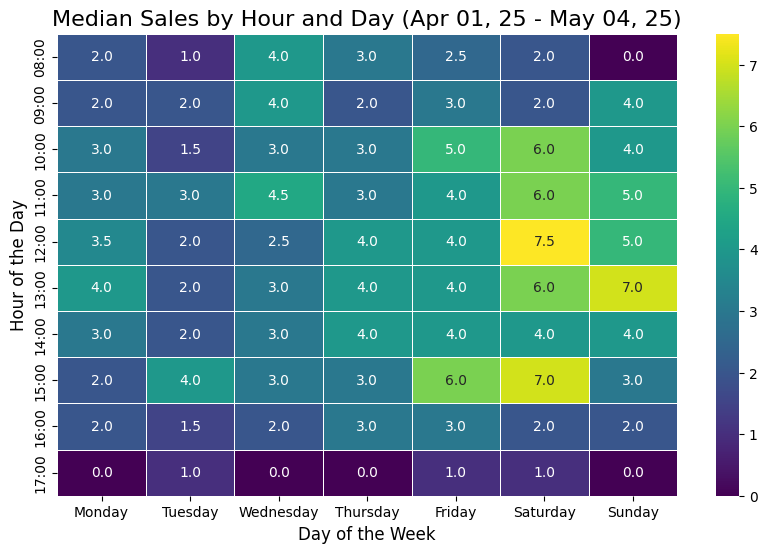

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_day_hour, annot=True, cmap='viridis', fmt='.1f', linewidths=0.5)

# Add labels and title
plt.title('Median Sales by Hour and Day (Apr 01, 25 - May 04, 25)', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Hour of the Day', fontsize=12)

# Show the plot
plt.show()

In [44]:
start_datetime = datetime.strptime('2024-10-10',  "%Y-%m-%d")
end_datetime = datetime.strptime('2025-05-08',  "%Y-%m-%d")
transactions = filtered_payments_df[(pd.to_datetime(filtered_payments_df['created_at.date']) >= start_datetime) & (pd.to_datetime(filtered_payments_df['created_at.date']) <= end_datetime)]

In [59]:
payments_df = transactions[~transactions['id'].isin(['rtG9yDKR5OExk2TDU03iaU5pvaB', 'P5lQjNEFQaGyNz9fJlMGFH8VuaB'])]

In [60]:
detailed_orders_data = []
detailed_orders_df = pd.DataFrame()

# Iterate through each order ID in payments_df['order_id']
for order_id in payments_df['order_id']:
    # Retrieve detailed order data using the Square API
    result = client.orders.retrieve_order(order_id=order_id)

    # Check if the request was successful
    if result.is_success():
        # Append the detailed order data to the list
        detailed_orders_data.append(result.body)
    else:
        # Print error message if there was an error
        print("Error:", result.errors)

# Normalize the list of dictionaries
normalized_data = [json_normalize(order) for order in detailed_orders_data]

# Concatenate the list of DataFrames
detailed_orders_df = pd.concat(normalized_data, ignore_index=True)

original_orders_df = detailed_orders_df.explode('order.line_items').reset_index()

In [65]:
detailed_orders_df = original_orders_df

detailed_orders_df[[
    'order.line_items.item_type',
    'order.line_items.catalog_object_id',
    'order.line_items.name',
    'order.line_items.variation_name',
    'order.line_items.quantity',
    'order.line_items.base_price_money.amount',
    'order.line_items.gross_sales_money.amount',
    'order.line_items.total_tax_money.amount',
    'order.line_items.total_discount_money.amount',
    'order.line_items.total_money.amount']] = json_normalize(detailed_orders_df['order.line_items'])[[
        'item_type',
        'catalog_object_id',
        'name',
        'variation_name',
        'quantity',
        'base_price_money.amount',
        'gross_sales_money.amount',
        'total_tax_money.amount',
        'total_discount_money.amount',
        'total_money.amount']]

transactions_df = payments_df.merge(detailed_orders_df, how='inner', left_on='order_id', right_on='order.id')[[
'id',
'order_id',
'created_at',
'receipt_number',
'amount_money.amount',
'tip_money.amount',
'total_money.amount',
'processing_fee.amount',
'refunded_money.amount',
'order.line_items.name',
'order.line_items.variation_name',
'order.line_items.quantity',
'order.line_items.base_price_money.amount',
'order.line_items.gross_sales_money.amount',
'order.line_items.total_discount_money.amount',
'order.line_items.total_tax_money.amount',
'order.line_items.total_money.amount']]

transactions_df[[
'amount_money.amount',
'tip_money.amount',
'total_money.amount',
'processing_fee.amount',
'refunded_money.amount',
'order.line_items.base_price_money.amount',
'order.line_items.gross_sales_money.amount',
'order.line_items.total_discount_money.amount',
'order.line_items.total_tax_money.amount',
'order.line_items.total_money.amount']] = transactions_df[['amount_money.amount',
                                                               'tip_money.amount',
                                                               'total_money.amount',
                                                               'processing_fee.amount',
                                                               'refunded_money.amount',
                                                               'order.line_items.base_price_money.amount',
                                                               'order.line_items.gross_sales_money.amount',
                                                               'order.line_items.total_discount_money.amount',
                                                               'order.line_items.total_tax_money.amount',
                                                               'order.line_items.total_money.amount']].astype('float64') / 100

transactions_df['created_at'] = pd.to_datetime(transactions_df['created_at'])

transactions_df['created_at.date'] = transactions_df['created_at'].dt.strftime('%Y-%m-%d')
transactions_df['created_at.hour'] = transactions_df['created_at'].dt.strftime('%I:%M %p')

#transactions_df = transactions_df.drop(columns=['created_at', 'amount_money.amount', 'processing_fee.amount', 'refunded_money.amount'])

# Get the current column order
current_columns = transactions_df.columns.tolist()

# Define the positions where you want to move the 'created_at.date' and 'created_at.hour' columns
date_position = 2  # 0-indexed position
hour_position = 3  # 0-indexed position

# Remove 'created_at.date' and 'created_at.hour' from the current position
current_columns.remove('created_at.date')
current_columns.remove('created_at.hour')

# Insert 'created_at.date' and 'created_at.hour' at the desired positions
current_columns.insert(date_position, 'created_at.date')
current_columns.insert(hour_position, 'created_at.hour')

# Reorder columns in the DataFrame
transactions_df = transactions_df[current_columns]
transactions_df.fillna(0, inplace=True)
transactions_df = transactions_df.drop(columns=['created_at'])
transactions_df

,id,order_id,created_at.date,created_at.hour,receipt_number,amount_money.amount,tip_money.amount,total_money.amount,processing_fee.amount,refunded_money.amount,order.line_items.name,order.line_items.variation_name,order.line_items.quantity,order.line_items.base_price_money.amount,order.line_items.gross_sales_money.amount,order.line_items.total_discount_money.amount,order.line_items.total_tax_money.amount,order.line_items.total_money.amount
0,LrNz5FmlHjRHc53MnKL635LXuaB,ovQOVbJxM0lbQwej3NvR0x7eV,2025-05-07,04:32 PM,LrNz,11.55,1.16,12.71,0.32,0.0,Hot Chocolate,Medium,2,5.50,11.00,0.0,0.55,11.55
1,ZO5y36kopZgaaZ11DHQYK1bDwaB,8nX8S2sbCza5GuG47mxJHRieV,2025-05-07,04:20 PM,ZO5y,21.52,0.00,21.52,0.23,0.0,Matcha Latte,Medium,1,5.50,5.50,0.0,0.27,5.77
2,ZO5y36kopZgaaZ11DHQYK1bDwaB,8nX8S2sbCza5GuG47mxJHRieV,2025-05-07,04:20 PM,ZO5y,21.52,0.00,21.52,0.23,0.0,Matcha Latte,Medium,1,5.50,5.50,0.0,0.27,5.77
3,ZO5y36kopZgaaZ11DHQYK1bDwaB,8nX8S2sbCza5GuG47mxJHRieV,2025-05-07,04:20 PM,ZO5y,21.52,0.00,21.52,0.23,0.0,Matcha Latte,Medium,1,5.50,5.50,0.0,0.27,5.77
4,j7V2b68LuauZqh8uZbBo7by4vaB,cZMSA8dNiJeY8YsWYaLNMq0eV,2025-05-07,04:02 PM,j7V2,5.51,0.55,6.06,0.15,0.0,Cajeta Latte,Medium,1,6.00,6.00,0.0,0.30,6.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6866,XfqMAJTTQm18FGo43MlBSPRCvaB,6YgKh4JxGvOIkwAnRvLT9WveV,2024-10-10,08:45 AM,XfqM,9.98,1.50,11.48,0.00,0.0,Horchata Latte,Large,2,6.75,13.50,0.0,0.00,13.50
6867,TTZWWI39Xcd7EB8ew9si86g8uaB,szdwV0BJajsszxYuL9dp6fleV,2024-10-10,08:44 AM,TTZW,9.45,0.00,9.45,0.19,0.0,Cappuccino,Medium,1,5.25,5.25,0.0,0.00,5.25
6868,TTZWWI39Xcd7EB8ew9si86g8uaB,szdwV0BJajsszxYuL9dp6fleV,2024-10-10,08:44 AM,TTZW,9.45,0.00,9.45,0.19,0.0,Cappuccino,Medium,1,5.25,5.25,0.0,0.00,5.25
6869,3rAcmPDOUuRHfeOkHdS3hwt0RnWZY,BfF5LZxhS5VM8rBdRiWNKzTWzoTZY,2024-10-10,08:10 AM,3rAc,12.86,0.00,12.86,0.13,0.0,Cappuccino,Medium,1,5.25,5.25,0.0,0.00,5.25


In [66]:
txns_subset = transactions_df[transactions_df['order.line_items.name'].isin(
                                                    ['Americano',
                                                     'Espresso',
                                                     'Horchata Latte', 
                                                     'Latte', 
                                                     'Cappuccino', 
                                                     'Regular Coffee', 
                                                     'Tea',
                                                     'Atole',
                                                     'Café Lechero',
                                                     'Mocha',
                                                     'Matcha Latte',
                                                     'Hot Chocolate',
                                                     'Frappuccino',
                                                     'Chai Latte',
                                                     'Chemex',
                                                     'Mazapan Latte',
                                                     'Flat White',
                                                     'London Fog',
                                                     'Horchata Water',
                                                     'Hibiscus Tea',
                                                     'Cajeta Latte',
                                                     'Iced Hibiscus Berry',
                                                     'Café De Olla Latte',
                                                     'Hibiscus Water',
                                                     'Cortado',
                                                     'Iced Hibiscus Berry Refresher',
                                                     'Jamaica Water'])
]


In [67]:
txns_subset

,id,order_id,created_at.date,created_at.hour,receipt_number,amount_money.amount,tip_money.amount,total_money.amount,processing_fee.amount,refunded_money.amount,order.line_items.name,order.line_items.variation_name,order.line_items.quantity,order.line_items.base_price_money.amount,order.line_items.gross_sales_money.amount,order.line_items.total_discount_money.amount,order.line_items.total_tax_money.amount,order.line_items.total_money.amount
0,LrNz5FmlHjRHc53MnKL635LXuaB,ovQOVbJxM0lbQwej3NvR0x7eV,2025-05-07,04:32 PM,LrNz,11.55,1.16,12.71,0.32,0.0,Hot Chocolate,Medium,2,5.50,11.00,0.0,0.55,11.55
1,ZO5y36kopZgaaZ11DHQYK1bDwaB,8nX8S2sbCza5GuG47mxJHRieV,2025-05-07,04:20 PM,ZO5y,21.52,0.00,21.52,0.23,0.0,Matcha Latte,Medium,1,5.50,5.50,0.0,0.27,5.77
2,ZO5y36kopZgaaZ11DHQYK1bDwaB,8nX8S2sbCza5GuG47mxJHRieV,2025-05-07,04:20 PM,ZO5y,21.52,0.00,21.52,0.23,0.0,Matcha Latte,Medium,1,5.50,5.50,0.0,0.27,5.77
3,ZO5y36kopZgaaZ11DHQYK1bDwaB,8nX8S2sbCza5GuG47mxJHRieV,2025-05-07,04:20 PM,ZO5y,21.52,0.00,21.52,0.23,0.0,Matcha Latte,Medium,1,5.50,5.50,0.0,0.27,5.77
4,j7V2b68LuauZqh8uZbBo7by4vaB,cZMSA8dNiJeY8YsWYaLNMq0eV,2025-05-07,04:02 PM,j7V2,5.51,0.55,6.06,0.15,0.0,Cajeta Latte,Medium,1,6.00,6.00,0.0,0.30,6.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6866,XfqMAJTTQm18FGo43MlBSPRCvaB,6YgKh4JxGvOIkwAnRvLT9WveV,2024-10-10,08:45 AM,XfqM,9.98,1.50,11.48,0.00,0.0,Horchata Latte,Large,2,6.75,13.50,0.0,0.00,13.50
6867,TTZWWI39Xcd7EB8ew9si86g8uaB,szdwV0BJajsszxYuL9dp6fleV,2024-10-10,08:44 AM,TTZW,9.45,0.00,9.45,0.19,0.0,Cappuccino,Medium,1,5.25,5.25,0.0,0.00,5.25
6868,TTZWWI39Xcd7EB8ew9si86g8uaB,szdwV0BJajsszxYuL9dp6fleV,2024-10-10,08:44 AM,TTZW,9.45,0.00,9.45,0.19,0.0,Cappuccino,Medium,1,5.25,5.25,0.0,0.00,5.25
6869,3rAcmPDOUuRHfeOkHdS3hwt0RnWZY,BfF5LZxhS5VM8rBdRiWNKzTWzoTZY,2024-10-10,08:10 AM,3rAc,12.86,0.00,12.86,0.13,0.0,Cappuccino,Medium,1,5.25,5.25,0.0,0.00,5.25


In [68]:
txns_subset[['created_at.date','order.line_items.name', 'order.line_items.quantity']]

,created_at.date,order.line_items.name,order.line_items.quantity
0,2025-05-07,Hot Chocolate,2
1,2025-05-07,Matcha Latte,1
2,2025-05-07,Matcha Latte,1
3,2025-05-07,Matcha Latte,1
4,2025-05-07,Cajeta Latte,1
...,...,...,...
6866,2024-10-10,Horchata Latte,2
6867,2024-10-10,Cappuccino,1
6868,2024-10-10,Cappuccino,1
6869,2024-10-10,Cappuccino,1


In [ ]:
# Convert `created_at.date` to datetime format
txns_subset['created_at.date'] = pd.to_datetime(txns_subset['created_at.date'])

# Convert `order.line_items.quantity` to integer
txns_subset['order.line_items.quantity'] = txns_subset['order.line_items.quantity'].astype(int)

# Define the reference date
reference_date = pd.to_datetime('2024-10-10')

# Calculate the difference in days
txns_subset['weeks_difference'] = (txns_subset['created_at.date'] - reference_date).dt.days // 7

# Display the updated DataFrame
txns_subset[['created_at.date', 'order.line_items.name', 'order.line_items.quantity', 'weeks_difference']]

/var/folders/gg/bq9f4z_51wzf2n5834ds3hmc0000gn/T/ipykernel_4158/3455464732.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  txns_subset['created_at.date'] = pd.to_datetime(txns_subset['created_at.date'])
/var/folders/gg/bq9f4z_51wzf2n5834ds3hmc0000gn/T/ipykernel_4158/3455464732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  txns_subset['weeks_difference'] = (txns_subset['created_at.date'] - reference_date).dt.days // 7


,created_at.date,order.line_items.name,order.line_items.quantity,weeks_difference
0,2025-05-07,Hot Chocolate,2,29
1,2025-05-07,Matcha Latte,1,29
2,2025-05-07,Matcha Latte,1,29
3,2025-05-07,Matcha Latte,1,29
4,2025-05-07,Cajeta Latte,1,29
...,...,...,...,...
6866,2024-10-10,Horchata Latte,2,0
6867,2024-10-10,Cappuccino,1,0
6868,2024-10-10,Cappuccino,1,0
6869,2024-10-10,Cappuccino,1,0


In [75]:
quantity_sum = txns_subset.groupby(['order.line_items.name', 'weeks_difference'])['order.line_items.quantity'].sum().reset_index()
quantity_sum

,order.line_items.name,weeks_difference,order.line_items.quantity
0,Americano,0,34
1,Americano,1,13
2,Americano,2,22
3,Americano,3,7
4,Americano,4,25
...,...,...,...
488,Tea,24,4
489,Tea,26,4
490,Tea,27,6
491,Tea,28,1


In [ ]:
# Pivot the `quantity_sum` DataFrame to create a matrix
quantity_matrix = quantity_sum.pivot(
    index='order.line_items.name', 
    columns='weeks_difference', 
    values='order.line_items.quantity'
)

# Fill NaN values with 0
quantity_matrix = quantity_matrix.fillna(0)

# Convert all values in the matrix to integers
quantity_matrix = quantity_matrix.astype(int)

# Calculate the median for each `order.line.items.name`, excluding zeros
quantity_matrix['Median'] = quantity_matrix.apply(
    lambda row: row[row > 0].median(), axis=1
).astype(int)  # Ensure the median is also an integer

# Sort the matrix by the 'Median' column
quantity_matrix = quantity_matrix.sort_values(by='Median', ascending=False)

# Apply color formatting to the matrix
def color_scale(val):
    """Apply a color scale based on the value."""
    color = f'background-color: rgba(0, 128, 0, {min(val / quantity_matrix.values.max(), 1)})'
    return color

# Use pandas Styler to apply the color scale
styled_matrix = quantity_matrix.style.applymap(color_scale)

# Display the styled matrix
styled_matrix

/var/folders/gg/bq9f4z_51wzf2n5834ds3hmc0000gn/T/ipykernel_4158/2300175573.py:33: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_matrix = quantity_matrix.style.applymap(color_scale)


weeks_difference,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,Median
order.line_items.name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Latte,87,70,44,55,60,56,19,23,44,41,25,25,27,52,27,46,40,20,38,46,47,43,53,55,42,42,52,63,49,46,45
Cappuccino,46,16,18,20,19,22,21,25,8,18,17,7,9,19,16,27,17,5,18,21,17,23,18,16,19,16,26,16,35,28,18
Americano,34,13,22,7,25,31,20,24,18,12,18,27,18,34,18,16,18,6,22,16,17,14,15,20,10,19,20,27,23,23,18
Horchata Latte,27,9,7,9,9,10,3,6,4,6,13,5,8,6,9,25,10,17,6,12,12,25,40,11,34,37,32,25,40,42,10
Regular Coffee,20,26,3,10,10,13,7,5,1,6,8,7,5,7,13,11,16,9,11,10,7,11,8,12,12,14,20,17,10,18,10
Café Lechero,16,0,9,8,17,11,4,6,6,9,16,6,20,27,4,8,11,7,2,13,15,21,19,19,4,5,11,8,14,9,9
Café De Olla Latte,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,5,0,8,10,9,2,9,16,8
Matcha Latte,11,10,16,7,10,12,3,4,3,3,5,3,8,5,5,3,7,5,3,9,8,11,9,11,10,10,7,8,12,8,8
Chai Latte,9,14,13,8,9,4,4,4,1,0,6,1,7,5,12,11,3,6,6,3,8,0,11,4,11,12,15,2,12,15,7
